<a href="https://colab.research.google.com/github/AlexWortega/Collab_experement/blob/main/Tinder_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Что это
* Автоматизация тиндера для поиска людей по нужным параметрам
# Зачем это?
* Я <s>погромист это фотошоп</s> мне можно я ебанутый
# Как запустить?
- Открываем https://tinder.com/
- Лезем в код элемента и оттуда в Network
- Затем лезем в XHR , вкладка Header и целенаправленно тыкаем содержимое
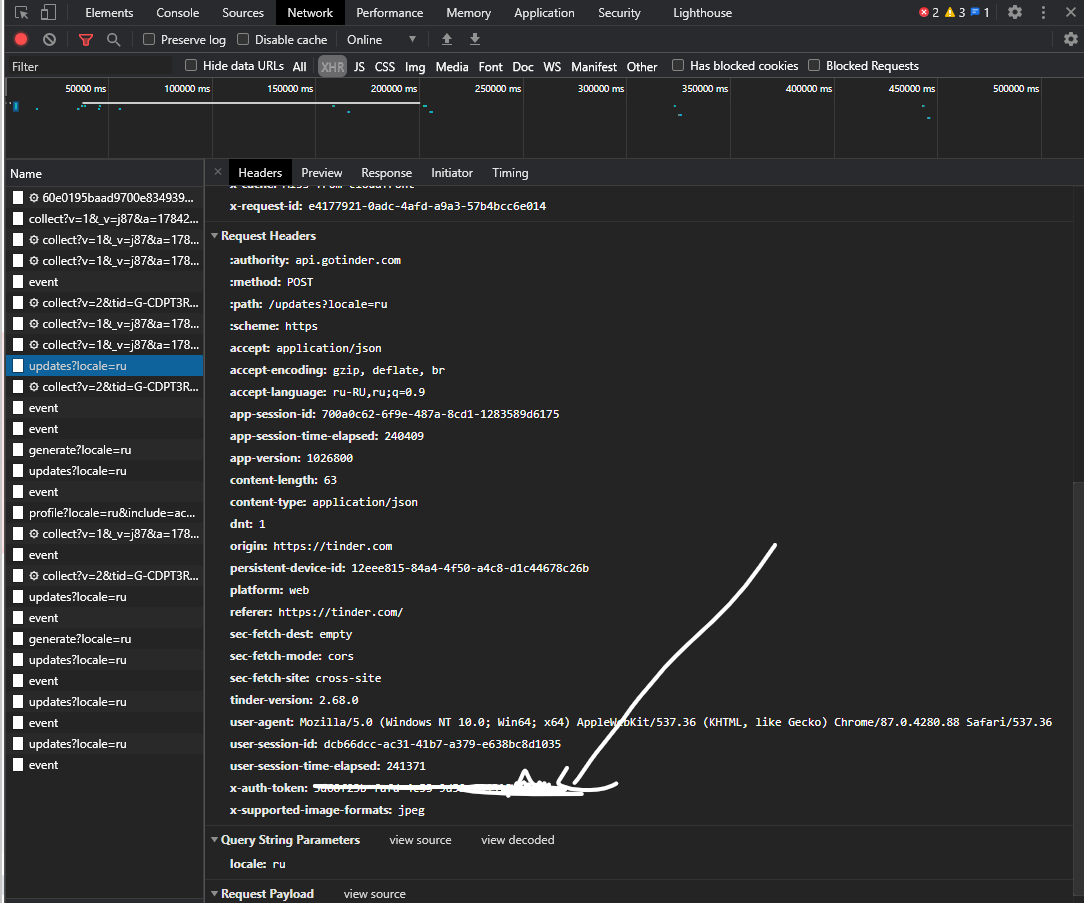

- Копируем Xauth ключ в переменную ниже, запускаем и полетели

In [ ]:
pip install geopy

In [ ]:
import datetime
from geopy.geocoders import Nominatim

AuthKey = '' 
#Сюда


TINDER_URL = "https://api.gotinder.com"
geolocator = Nominatim(user_agent="auto-tinder")
PROF_FILE = "./images/unclassified/profiles.txt"

class Person(object):

    def __init__(self, data, api):
        self._api = api

        self.id = data["_id"]
        self.name = data.get("name", "Unknown")

        self.bio = data.get("bio", "")
        self.distance = data.get("distance_mi", 0) / 1.60934

        self.birth_date = datetime.datetime.strptime(data["birth_date"], '%Y-%m-%dT%H:%M:%S.%fZ') if data.get(
            "birth_date", False) else None
        self.gender = ["Male", "Female", "Unknown"][data.get("gender", 2)]

        self.images = list(map(lambda photo: photo["url"], data.get("photos", [])))

        self.jobs = list(
            map(lambda job: {"title": job.get("title", {}).get("name"), "company": job.get("company", {}).get("name")}, data.get("jobs", [])))
        self.schools = list(map(lambda school: school["name"], data.get("schools", [])))

        if data.get("pos", False):
            self.location = geolocator.reverse(f'{data["pos"]["lat"]}, {data["pos"]["lon"]}')

    def download_images(self, folder=".", sleep_max_for=0):
        with open(PROF_FILE, "r") as f:
            lines = f.readlines()
            if self.id in lines:
                return
        with open(PROF_FILE, "a") as f:
            f.write(self.id+"\r\n")
        index = -1
        for image_url in self.images:
            index += 1
            req = requests.get(image_url, stream=True)
            if req.status_code == 200:
                with open(f"{folder}/{self.id}_{self.name}_{index}.jpeg", "wb") as f:
                    f.write(req.content)
            sleep(random()*sleep_max_for)
    def __repr__(self):
        return f"{self.id}  -  {self.name} ({self.birth_date.strftime('%d.%m.%Y')})"


    def like(self):
        return self._api.like(self.id)

    def dislike(self):
        return self._api.dislike(self.id)

In [ ]:
import requests

TINDER_URL = "https://api.gotinder.com"

class tinderAPI():

    def __init__(self, token):
        self._token = token

    def profile(self):
        data = requests.get(TINDER_URL + "/v2/profile?include=account%2Cuser", headers={"X-Auth-Token": self._token}).json()
        return Profile(data["data"], self)

    def matches(self, limit=10):
        data = requests.get(TINDER_URL + f"/v2/matches?count={limit}", headers={"X-Auth-Token": self._token}).json()
        return list(map(lambda match: Person(match["person"], self), data["data"]["matches"]))

    def like(self, user_id):
        data = requests.get(TINDER_URL + f"/like/{user_id}", headers={"X-Auth-Token": self._token}).json()
        return {
            "is_match": data["match"],
            "liked_remaining": data["likes_remaining"]
        }

    def dislike(self, user_id):
        requests.get(TINDER_URL + f"/pass/{user_id}", headers={"X-Auth-Token": self._token}).json()
        return True

    def nearby_persons(self):
        data = requests.get(TINDER_URL + "/v2/recs/core", headers={"X-Auth-Token": self._token}).json()
        
        return list(map(lambda user: Person(user["user"], self), data["data"]["results"]))

In [ ]:


if __name__ == "__main__":
    token = AuthKey 
    api = tinderAPI(token)

    while True:
        persons = api.nearby_persons()
        for person in persons:
           #тут нет логики, напишите сами если захотит
            print(person)
            person.like()
            print(person.bio)
            